## Introduction
This tutorial is for people who are relatively new to machine learning. I'll get you through all the steps from importing the data to making predictions on the test set. I don't think there is a better way to start machine learning than from the Titanic Survival Prediction Challenge here on Kaggle. It is the first thing you should be able to solve on your own after learning ML. When I first started out I didn't do all that well, infact my first submission scored only 0.36, more than anything I didn't know what to do even after knowing what pandas, sklearn etc.. was all about. If you're in a similar position then it is for you too. If you read through the code you must be able to understand what I'm doing and how it must be done. And don't expect every ML problem to be as simple as this one, this is just to get you started. Anyways what you learn from this notebook may be applicable to some other real-world problems as well. Let's get started. 

And one more thing,

#### If you find the kernel useful or cool please give an UPVOTE to show your appreciation. 
(I'm sure this kernel would be a lot helpful for beginners)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)
        
import os
print(os.listdir("../input"))

#Import visualization libraries
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Seaborn is also a visualization lib, it's actually pretty cool
import seaborn as sns

from collections import Counter

# Suppress Future Warnings (Safe Step)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

['titanic', 'private-best-score']


## Loading the Data
The first step in any Dat Science workflow is to load the data. It's commonly done using pandas's `pd.read_csv` function. It is also one of the most used functions in Data Science.

In [2]:
# Load train and test data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# head method prints the first 5 rows of a DataFrame
print(train.head())

   PassengerId  Survived   ...     Cabin Embarked
0            1         0   ...       NaN        S
1            2         1   ...       C85        C
2            3         1   ...       NaN        S
3            4         1   ...      C123        S
4            5         0   ...       NaN        S

[5 rows x 12 columns]


In [3]:
# Information about the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We can see a lot of missing values these, we'll go on to fix them later. Before I get started I always like to drop the outliers in the data, if there aren't many of course.

## Detecting and Fixing Outliers
I wrote a function here to detect outliers. Feel free to use this fuction for your other projects as well. Honestly, we don't always keep writing the same functions over and over again for all projects, we write once and copy if it is ever needed again.

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
train.loc[Outliers_to_drop]

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,PassengerId,Survived,...,Cabin,Embarked
27,28,0,...,C23 C25 C27,S
88,89,1,...,C23 C25 C27,S
159,160,0,...,NaN,S
180,181,0,...,NaN,S
201,202,0,...,NaN,S
324,325,0,...,NaN,S
341,342,1,...,C23 C25 C27,S
792,793,0,...,NaN,S
846,847,0,...,NaN,S
863,864,0,...,NaN,S


In [5]:
# Drop outliers with the help of pandas drop method
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## Fixing Missing Values
Everything will be pretty much intuitive here except for the way I'm dealing the cabin feature of our data. When a ship sinks and if you're inside, the most important thing that decides whether you live or you die is the cabin you're in. And cabin data is largely unknown. For this reason I havn't imputed cabin's values with the most frequently occuring value, instead we keep unknown cabins as a seperate value as you'll see.

In [6]:
# Fill missing values with NaN
train = train.fillna(np.nan)
test = test.fillna(np.nan)

print("============= Train Data Info =============")
print(train.info())
print("============= Test Data Info =============")
print(test.info())

# Check for Null values
print("=========== Missing Values Train =============")
print(train.isnull().sum())
print("=========== Missing Values Test =============")
print(test.isnull().sum())

============= Train Data Info =============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB
None
============= Test Data Info =============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch     

In [7]:
train["Cabin"][train["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [8]:
# Replace the Cabin number by the type of cabin 'X' if not
def fix_cabin(data):
    data["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in data['Cabin'] ])
fix_cabin(train)
fix_cabin(test)

In [9]:
# IMPUTING MISSING VALUES
def fill_missing_values(df):
    ''' This function imputes missing values with median for numeric columns 
        and most frequent value for categorical columns'''
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    for column in list(missing.index):
        if df[column].dtype == 'object':
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        elif df[column].dtype == 'int64' or 'float64' or 'int16' or 'float16':
            df[column].fillna(df[column].median(), inplace=True)

In [10]:
fill_missing_values(train)
fill_missing_values(test)

In [11]:
# Check for Null values
print("=========== Missing Values Train =============")
print(train.isnull().sum())
print("=========== Missing Values Test =============")
print(test.isnull().sum())

=========== Missing Values Train =============
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64
=========== Missing Values Test =============
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## Exploratory Data Analysis (EDA)
In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. We're going to do exactly that in this section, get ready for some cool visualizations.

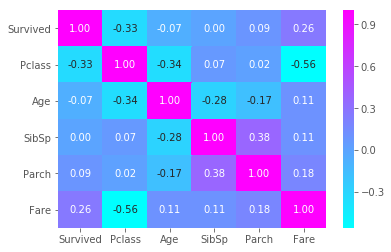

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train.iloc[:, 1:].corr(),
                annot=True, 
                fmt = ".2f", 
                cmap = "cool")

One interesting observation from the above graph is how Passenger class and their survival are correlated.

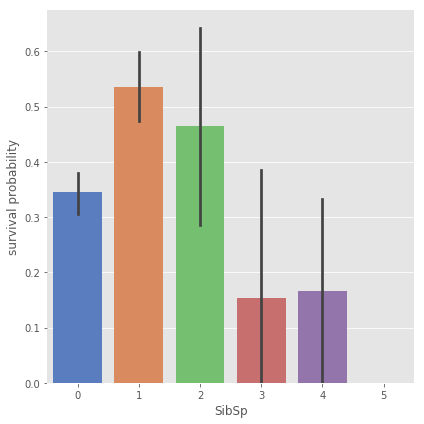

In [13]:
# Explore SibSp feature vs Survived
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Here it's clear that people with more number of siblings/spouse onboard had a lesser chance of survival. And people who were alone also had relatively low chances of survival. 

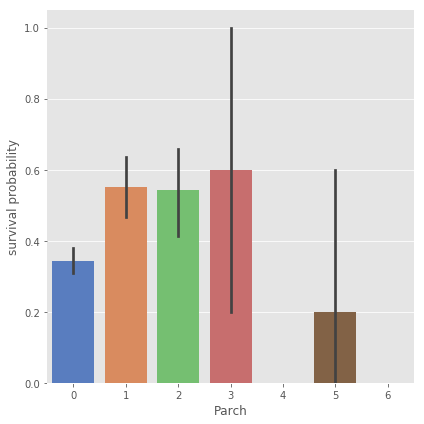

In [14]:
# Explore Parch feature vs Survived
g  = sns.catplot(x="Parch", y="Survived", data=train,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Again people with more number of children/parents on board haven'y survived, neither did people who were travelling alone. Poeple with Parch size of 3 have survived maybe it was the right size to help each other out. 

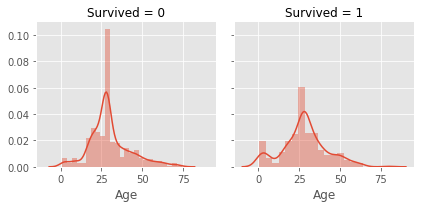

In [15]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

We can see clearly that the youth have survived more than elderly men, and they've also lost more lives which means there were more youths onboard. 

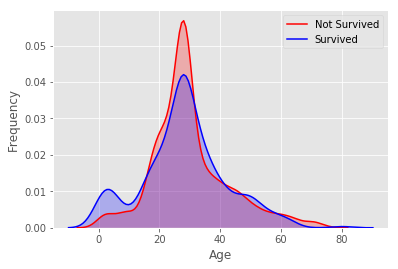

In [16]:
# Explore Age distibution 
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

That tiny spike on the left handside shows that more young kids on board survived. I'll leave the rest to you.

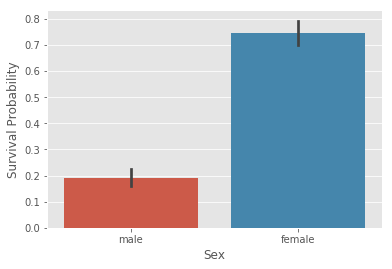

In [17]:
g = sns.barplot(x="Sex",y="Survived",data=train)
g = g.set_ylabel("Survival Probability")

Whoa, a staggering number of females have survived compared to men, which can only mean women and children were given higher preference to get into life boats.

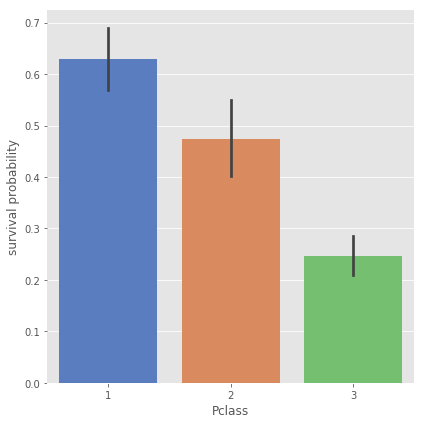

In [18]:
# Explore Pclass vs Survived
g = sns.catplot(x="Pclass",y="Survived",data=train,kind="bar", height = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

No surprise, first class passengers have survived more than the rest. Unfortunately lower class passengers mostly didn't make it.

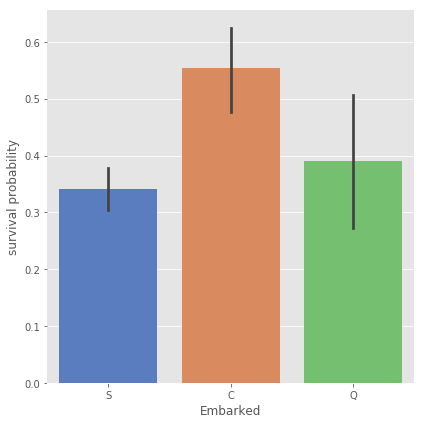

In [19]:
# Explore Embarked vs Survived 
g = sns.catplot(x="Embarked", y="Survived",  data=train,
                   height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Here it looks like passengers from Cherbourg have had the highest chance of survival when compared to Queenstown and Southamptom.

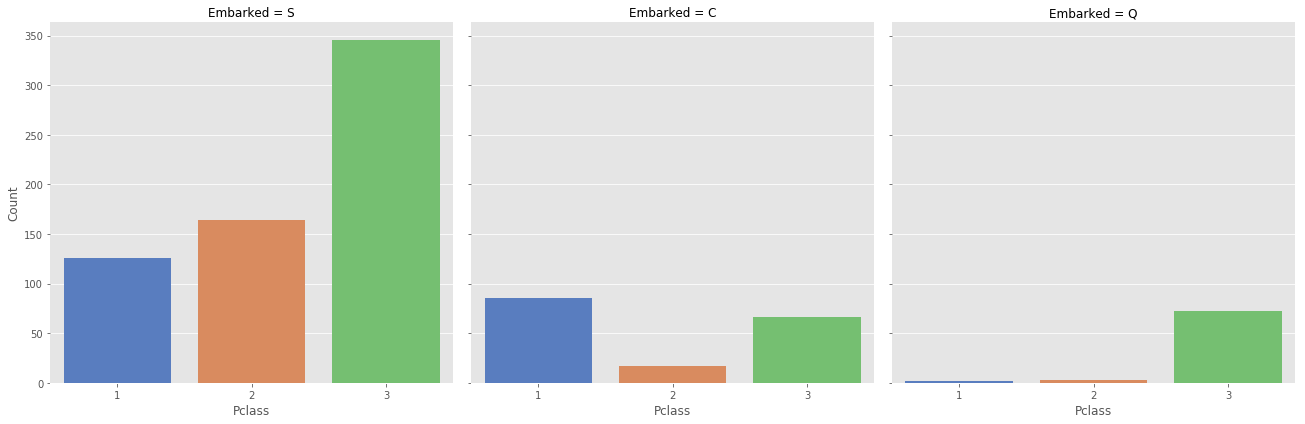

In [20]:
# Explore Pclass vs Embarked 
g = sns.catplot("Pclass", col="Embarked",  data=train,
                   height=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

Most people from Southamptom belong to class 3 that's why they have the lowest chances of survival. When you look at Cherbourg there are very less people but most of them are higher class passengers while Queenstown have mostly lower class passengers.

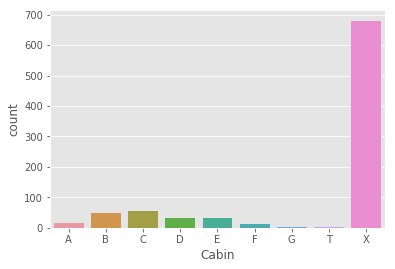

In [21]:
g = sns.countplot(train["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

Look at that, if we had dropped cabin we'd have lost so many information. And also if we had imputed it with most frequest value it wouldn't have made sense. It looks much better to have it as a seperate feature.

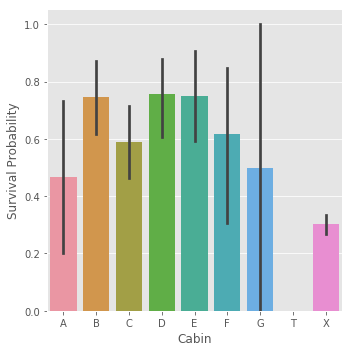

In [22]:
g = sns.catplot(y="Survived",x="Cabin",data=train,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

More people from unknown cabin have lost their lives, while B, D, and E have the highest survival probability.

## Feature Engineering
Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. For example we are extracting titles from names and see the relations with other data points if it is significant then we can think about adding them as a seperate feature. Also machine learning algorithms can only deal with numbers as long as we're not talking about sequence models, so we'll fix categorical and test based featured as well.

Note: I have applied the same feature engineering to the test data as well otherwise we'll have a feature mismatch while making prediction.

In [23]:
# Get Title from Name
def get_title(data):
    data_title = [i.split(",")[1].split(".")[0].strip() for i in data["Name"]]
    data["Title"] = pd.Series(data_title)
    data["Title"].head()
get_title(train)
train['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [24]:
get_title(test)
test['Title'].head()

0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object

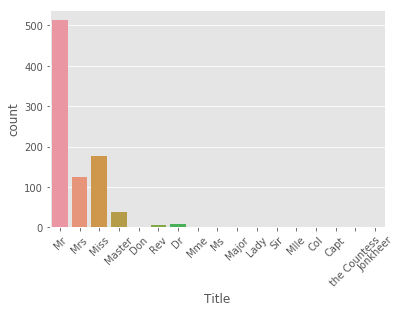

In [25]:
g = sns.countplot(x="Title",data=train)
g = plt.setp(g.get_xticklabels(), rotation=45)

We can see only about 4 titles repeating often so we keep them and name all the others "rare"

In [26]:
# Convert to categorical values Title 
def convert_title(data):
    data["Title"] = data["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col',
                                             'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    data["Title"] = data["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
    data["Title"] = data["Title"].astype(int)
convert_title(train)
convert_title(test)

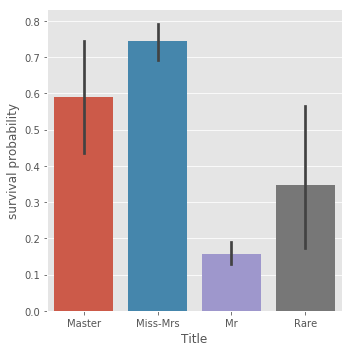

In [27]:
g = sns.catplot(x="Title",y="Survived",data=train,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

Boys, Girls and Women have higher chance of survival where the men have the lowest. Which again makes sense.

In [28]:
# Drop Name variable
train.drop(labels = ["Name"], axis = 1, inplace = True)
test.drop(labels=["Name"], axis=1, inplace=True)

In [29]:
# Create a family size descriptor from SibSp and Parch
train["Fsize"] = train["SibSp"] + train["Parch"] + 1
test["Fsize"] = test["SibSp"] + train["Parch"] + 1

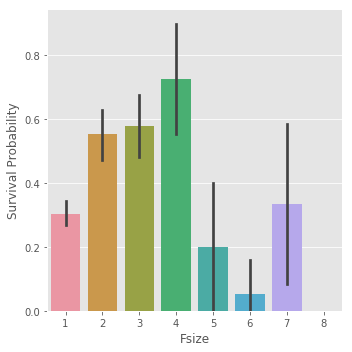

In [30]:
g = sns.catplot(x="Fsize",y="Survived",data=train, kind='bar')
g = g.set_ylabels("Survival Probability")

As we have seen before larger families and lone passengers have the least chance of survival.

In [31]:
# Create new feature of family size
def create_fsize(data):
    data['Single'] = data['Fsize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallF'] = data['Fsize'].map(lambda s: 1 if  s == 2  else 0)
    data['MedF'] = data['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    data['LargeF'] = data['Fsize'].map(lambda s: 1 if s >= 5 else 0)
create_fsize(train)
create_fsize(test)

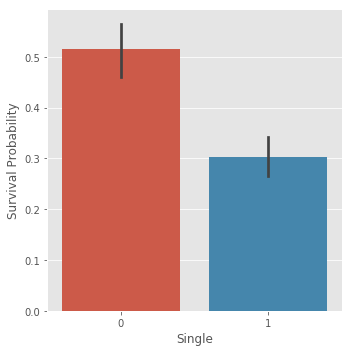

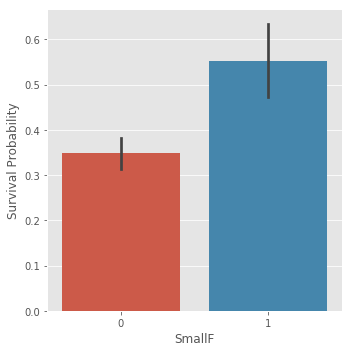

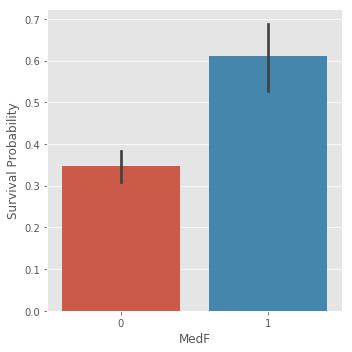

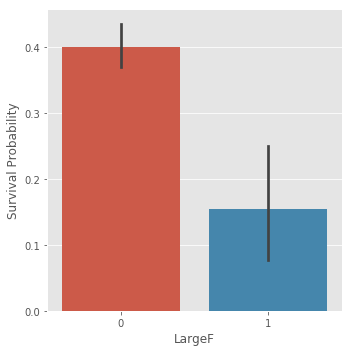

In [32]:
g = sns.catplot(x="Single",y="Survived",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="SmallF",y="Survived",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="MedF",y="Survived",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(x="LargeF",y="Survived",data=train,kind="bar")
g = g.set_ylabels("Survival Probability")

There 4 graphs again reiterate the same fact in much more detail.

In [33]:
# convert to indicator values Title and Embarked 
def encode_train_embark(data):
    '''Encoding Categorical variable Embarked'''
    data = pd.get_dummies(data, columns = ["Title"])
    data = pd.get_dummies(data, columns = ["Embarked"], prefix="Em")
encode_train_embark(train)
encode_train_embark(test)

In [34]:
train['Cabin'] = train['Cabin'].map({'X': 1, 'C': 2, 'B': 3, 'D': 4, 'E': 5, 'A': 6, 'F': 7, 'G': 8, 'T': 9})
test['Cabin'] = test['Cabin'].map({'X': 1, 'C': 2, 'B': 3, 'D': 4, 'E': 5, 'A': 6, 'F': 7, 'G': 8, 'T': 9})

In [35]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
Fsize          0
Single         0
SmallF         0
MedF           0
LargeF         0
dtype: int64

In [36]:
# Create categorical values for Pclass
train["Pclass"] = train["Pclass"].astype("category")
train = pd.get_dummies(train, columns = ["Pclass"],prefix="Pc")

test["Pclass"] = test["Pclass"].astype("category")
test = pd.get_dummies(test, columns = ["Pclass"],prefix="Pc")

In [37]:
# Drop useless variables 
train.drop(labels = ["PassengerId", "Ticket"], axis = 1, inplace=True)
test.drop(labels = ["PassengerId", "Ticket"], axis=1, inplace=True)

In [38]:
from sklearn.preprocessing import LabelEncoder
def impute_cats(df):
    '''This function converts categorical and non-numeric 
       columns into numeric columns to feed into a ML algorithm'''
    # Find the columns of object type along with their column index
    object_cols = list(df.select_dtypes(exclude=[np.number]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers    
    label_enc = LabelEncoder()
    for i in object_cols_ind:
        df.iloc[:,i] = label_enc.fit_transform(df.iloc[:,i])

In [39]:
# Impute the categorical values
impute_cats(train)
impute_cats(test)
print("Train Dtype counts: \n{}".format(train.dtypes.value_counts()))
print("Test Dtype counts: \n{}".format(test.dtypes.value_counts()))

Train Dtype counts: 
int64      12
uint8       3
float64     2
dtype: int64
Test Dtype counts: 
int64      10
float64     3
uint8       3
dtype: int64


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 17 columns):
Survived    881 non-null int64
Sex         881 non-null int64
Age         881 non-null float64
SibSp       881 non-null int64
Parch       881 non-null int64
Fare        881 non-null float64
Cabin       881 non-null int64
Embarked    881 non-null int64
Title       881 non-null int64
Fsize       881 non-null int64
Single      881 non-null int64
SmallF      881 non-null int64
MedF        881 non-null int64
LargeF      881 non-null int64
Pc_1        881 non-null uint8
Pc_2        881 non-null uint8
Pc_3        881 non-null uint8
dtypes: float64(2), int64(12), uint8(3)
memory usage: 99.0 KB


In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
Sex         418 non-null int64
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Cabin       418 non-null int64
Embarked    418 non-null int64
Title       418 non-null int64
Fsize       418 non-null float64
Single      418 non-null int64
SmallF      418 non-null int64
MedF        418 non-null int64
LargeF      418 non-null int64
Pc_1        418 non-null uint8
Pc_2        418 non-null uint8
Pc_3        418 non-null uint8
dtypes: float64(3), int64(10), uint8(3)
memory usage: 43.8 KB


### If you like this kernel please consider giving it an UPVOTE.

## Building, Training and Validating our Models
This is where real Machine Learning is done. There must be one thing which must be pretty clear to you now. Machine Learning needs Data Science skills as well. Without the above steps we can't build an accurate model. 

I've tuned the hyperparameter based on previous experience, you might have to try and a lot of variables to pick the best performing set of parameters or use something like GridSearchCV.

In [42]:
# import the models
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# Package for stacking models
from vecstack import stacking

In [43]:
# Seperate out feature and target variables
y = train['Survived']
X = train.drop('Survived', axis=1)

In [44]:
def train_model(classifier, name="Classifier"):
    '''This function is used to train and print the accuracy of our models'''
    
    folds = StratifiedKFold(n_splits=5, random_state=42)
    accuracy = np.mean(cross_val_score(classifier, X, y, scoring="accuracy", cv=folds, n_jobs=-1))
    if name not in alg_list: alg_list.append(name)
    print(f"{name} Accuracy: {accuracy}")
    return accuracy

In [45]:
# Lists that keep track cross val means and algorithm names
cv_means = []
alg_list = []

### Logistic Regression

In [46]:
# Initialize the model
log_reg = LogisticRegression(C=5, penalty='l2',random_state=42)
# Validate the model
log_reg_acc = train_model(log_reg, "Logistic Regression")
cv_means.append(log_reg_acc)
# Fit the best performing model to training data
log_reg.fit(X, y)

Logistic Regression Accuracy: 0.8229070364663584


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Support Vector Machine Classifier

In [47]:
# Initialize the model
svm = SVC(C=5, random_state=42)
# Validate the model
svm_acc = train_model(svm, "Support Vector Machine")
cv_means.append(svm_acc)
# Fit the best performing model to training data
svm.fit(X, y)

Support Vector Machine Accuracy: 0.750321006676939


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

### Random Forest

In [48]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=300, max_depth=25, 
                                min_samples_split=2, min_samples_leaf=2,
                                max_features="log2", random_state=12)
# Validate the model
rf_acc = train_model(rf, "Random Forest")
cv_means.append(rf_acc)
# Fit the best performing model to training data
rf.fit(X, y)

Random Forest Accuracy: 0.8365434001027221


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

### Linear Discriminant Analysis

In [49]:
# Initialize the model
lda = LinearDiscriminantAnalysis(solver='lsqr')
# Validate the model
lda_acc = train_model(lda, "Linear Discriminant Analysis")
cv_means.append(lda_acc)
# Fit the best performing model to training data
lda.fit(X, y)

Linear Discriminant Analysis Accuracy: 0.8251733436055471


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='lsqr', store_covariance=False, tol=0.0001)

### Multi-Layer Perceptron

In [50]:
# Initialize the model
mlp = MLPClassifier(hidden_layer_sizes=(50, 10), activation='relu', solver='adam', 
                    alpha=0.01, batch_size=32, learning_rate='constant', 
                    shuffle=False, random_state=42, early_stopping=True, 
                    validation_fraction=0.2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
# Validate the model
mlp_acc = train_model(mlp, "MLP")
cv_means.append(mlp_acc)
# Fit the best performing model to training data
mlp.fit(X, y)

MLP Accuracy: 0.8025423728813561


MLPClassifier(activation='relu', alpha=0.01, batch_size=32, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=False, solver='adam', tol=0.0001,
       validation_fraction=0.2, verbose=False, warm_start=False)

### XGBoost (Extreme Gradient Boosting)

In [51]:
# Initialize the model
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, n_jobs=-1, nthread=-1, 
                    gamma=0.06, min_child_weight=5, 
                    subsample=1, colsample_bytree=0.9, 
                    reg_alpha=0, reg_lambda=0.5, 
                    random_state=42)
# Validate the model
xgb_acc = train_model(xgb, "XgBoost")
cv_means.append(xgb_acc)
# Fit the best performing model to training data
xgb.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


XgBoost Accuracy: 0.8501861838726246


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.06, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=-1, nthread=-1,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

### LightGBM (Light Gradient Boosting)

In [52]:
# Initialize the model
lgbm = LGBMClassifier(num_leaves=31, learning_rate=0.1, 
                      n_estimators=64, random_state=42, n_jobs=-1)
# Validate the model
lgbm_acc = train_model(lgbm, "LGBM")
cv_means.append(lgbm_acc)
# Fit the best performing model to training data
lgbm.fit(X, y)

LGBM Accuracy: 0.8433808423215202


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=64, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Performance

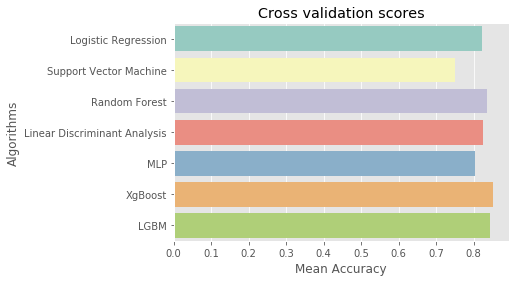

In [53]:
# Create a performance DF with score and Algorithm name
performance_df = pd.DataFrame({"Algorithms": alg_list, "CrossValMeans":cv_means})

# Plot the performace of all models
g = sns.barplot("CrossValMeans","Algorithms", data = performance_df, palette="Set3",orient = "h")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## Model Stacking

Stacking is an ensemble learning technique that uses predictions from multiple models to build a new model. This model is used for making predictions on the test set. We pick some of the best performing models to be the first layer of the stack while XGB is set at layer 2 to make the final prediction. We use a package called **vecstack** to implement model stacking.  It's actually very easy to use, you can have a look at the [documentation](https://github.com/vecxoz/vecstack) for more information.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
# First level models
models = [rf, lda, lgbm]

In [56]:
# Perform Stacking
S_train, S_test = stacking(models,
                           X_train, y_train, X_test,
                           regression=False,
                           mode='oof_pred_bag',
                           n_folds=5,
                           save_dir=None,
                           needs_proba=False,
                           random_state=42,
                           stratified=True,
                           shuffle=True,
                           verbose=2
                          )

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.82978723]
    fold  1:  [0.80851064]
    fold  2:  [0.81560284]
    fold  3:  [0.80851064]
    fold  4:  [0.81428571]
    ----
    MEAN:     [0.81533941] + [0.00778696]
    FULL:     [0.81534091]

model  1:     [LinearDiscriminantAnalysis]
    fold  0:  [0.86524823]
    fold  1:  [0.78014184]
    fold  2:  [0.82269504]
    fold  3:  [0.81560284]
    fold  4:  [0.81428571]
    ----
    MEAN:     [0.81959473] + [0.02718273]
    FULL:     [0.81960227]

model  2:     [LGBMClassifier]
    fold  0:  [0.80141844]
    fold  1:  [0.80141844]
    fold  2:  [0.80141844]
    fold  3:  [0.80141844]
    fold  4:  [0.82142857]
    ----
    MEAN:     [0.80542047] + [0.00800405]
    FULL:     [0.80539773]



In [57]:
# Fit the 2nd level model on the output of level 1
xgb.fit(S_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.06, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=-1, nthread=-1,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [58]:
# Make predictions on the localized test set
stacked_pred = xgb.predict(S_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, stacked_pred))

Final prediction score: [0.84745763]


## Predictions
Now it is finally time to make predictions on the real world test data. The approach here might look strange to you. You can visit [this link](https://github.com/vecxoz/vecstack/issues/4) to understand how it is done.

In [59]:
y1_pred_L1 = models[0].predict(test)
y2_pred_L1 = models[1].predict(test)
y3_pred_L1 = models[2].predict(test)
S_test_L1 = np.c_[y1_pred_L1, y2_pred_L1, y3_pred_L1]

In [60]:
test_stacked_pred = xgb.predict(S_test_L1)
xgb.fit(X, y)
xgb_pred = xgb.predict(test)
rf_pred = rf.predict(test)
lda_pred = lda.predict(test)

## Submission Files
I'm leaving you to play around with this kernel to improve this even further. This is just for illustration purposes still this kernel can score 79/80 on the public Lb as I've tested. However if you're a leaderboard pixie and want to climb the LB to have some fun (let's accept as beginners we all wanted that), I'm giving you my Personal Best submission file as well.

In [61]:
old_test = pd.read_csv('../input/titanic/test.csv')

submission = pd.DataFrame({'PassengerId':old_test['PassengerId'], 'Survived': test_stacked_pred})
xgb_sub = pd.DataFrame({'PassengerId':old_test['PassengerId'], 'Survived': xgb_pred})
rf_sub = pd.DataFrame({'PassengerId':old_test['PassengerId'], 'Survived': rf_pred})
lda_sub = pd.DataFrame({'PassengerId':old_test['PassengerId'], 'Survived': lda_pred})

submission.to_csv("stacked_submission.csv", index=False)
xgb_sub.to_csv("xgboost_submission.csv", index=False)
rf_sub.to_csv("random_forest_submission.csv", index=False)
lda_sub.to_csv("lda_submission.csv", index=False)

best_score = pd.read_csv('../input/private-best-score/best_score (1).csv')
best_score.to_csv('best_score.csv', index=False)

### If you like this kernel and you've made it so far please give an UPVOTE to show your appreciation.

### **Authored By:**
[Abhinand](https://www.kaggle.com/abhinand05)